In [59]:
from MyViT.utils import MRISegDataset
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

In [60]:
IMAGE_SIZE = (1,128,128)
NUM_PATCHES = 32

train_image_dataset = MRISegDataset('data/mri_data_seg/images/train/', transform=ToTensor(),image_shape = IMAGE_SIZE[1])
train_image_loader  = DataLoader(train_image_dataset, shuffle=False, batch_size=128)

train_mask_dataset = MRISegDataset('data/mri_data_seg/masks/train/', transform=ToTensor(),image_shape = IMAGE_SIZE[1])
train_mask_loader  = DataLoader(train_mask_dataset, shuffle=False, batch_size=128)


500


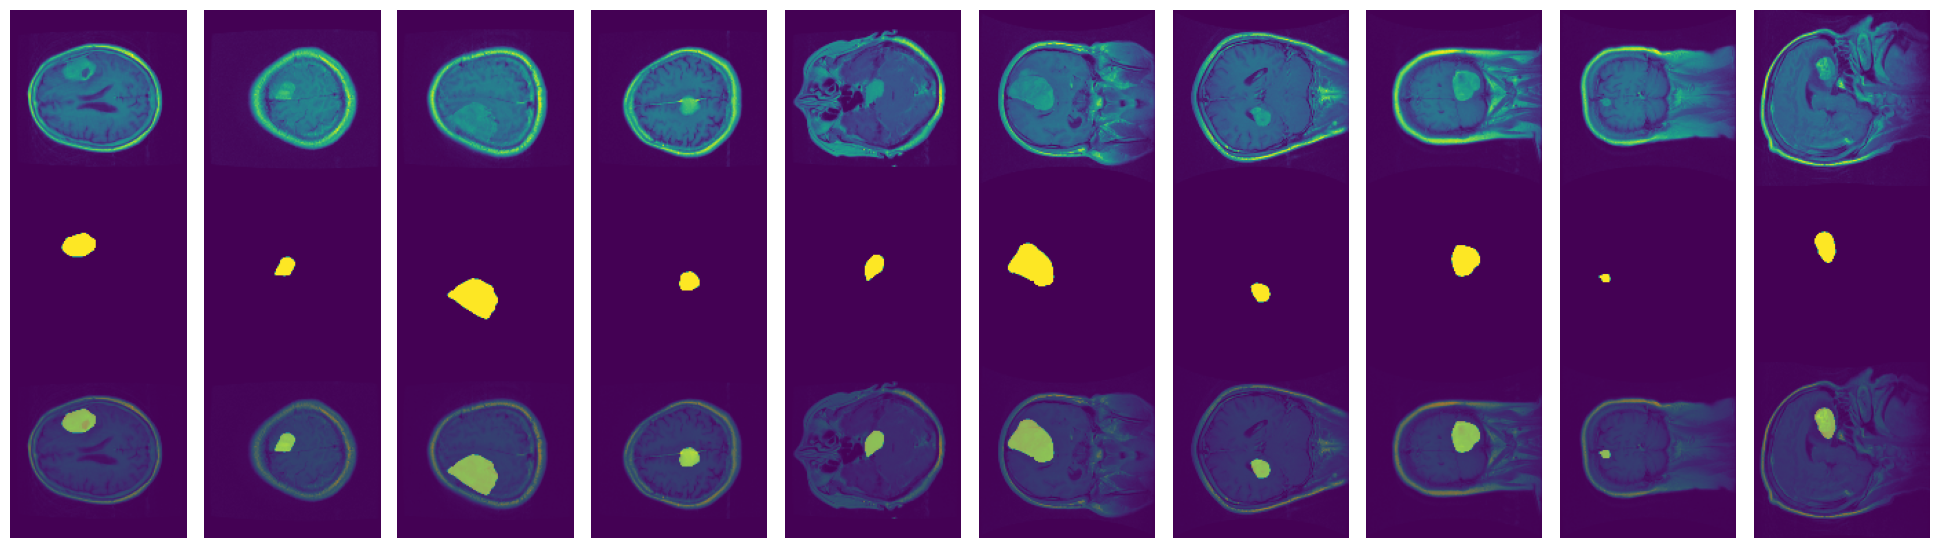

In [61]:
# import numpy as np
import random
num_train_tumor_files = len(train_image_dataset)
# print(num_train_tumor_files)
train_files_to_display = random.sample(range(num_train_tumor_files), k=10)
# print(train_files_to_display)
img_count = 0
image_and_mask_dict = {}

plt.figure(figsize=(25,6))
plt.subplots_adjust(wspace=0, hspace=0,bottom=0)
for i, (image, mask) in enumerate(zip(train_image_dataset,train_mask_dataset)):
    # print(i, (i  in train_files_to_display))
    if (i in train_files_to_display):
        img_count = img_count+1
        # Convert the tensor back to a PIL image for display
        to_pil = ToPILImage()
        image_pil = to_pil(image)
        mask_pil = to_pil(mask)

        # Display the image
        plt.subplot(3,10,img_count)
        plt.imshow(image_pil)
        plt.axis('off')

        plt.subplot(3,10,img_count+10)
        plt.imshow(mask_pil)
        plt.axis('off')


        plt.subplot(3,10,img_count+20)
        plt.imshow(image_pil)
        plt.imshow(mask_pil,alpha=0.5)
        plt.axis('off')
        
    image_and_mask_dict[image] = mask
        

print(len(image_and_mask_dict))





In [62]:
import os

# Lists to store file paths for training and validation images and masks
image_paths_train = []
label_paths_train = []

image_paths_validation = []
label_paths_validation = []

# Iterate through sorted files in the training images directory
train_images_path = 'data/mri_data_seg/images/train/'
train_masks_path = 'data/mri_data_seg/masks/train/'
test_images_path = 'data/mri_data_seg/images/test/'
test_masks_path = 'data/mri_data_seg/masks/test/'

for file1 in sorted(os.listdir(train_images_path)):
    image_paths_train.append(train_images_path + file1)

for file2 in sorted(os.listdir(train_masks_path)):
    label_paths_train.append(train_masks_path + file2)

for file3 in sorted(os.listdir(test_images_path)):
    image_paths_validation.append(test_images_path + file3)

for file4 in sorted(os.listdir(test_masks_path)):
    label_paths_validation.append(test_masks_path + file4)

# Import necessary classes from the datasets module
from datasets import Dataset, DatasetDict, Image

def create_dataset(image_paths, label_paths):
    dataset = Dataset.from_dict({"pixel_values": sorted(image_paths),"label": sorted(label_paths)})
    dataset = dataset.cast_column("pixel_values", Image())
    dataset = dataset.cast_column("label", Image())
    return dataset

#  Create Dataset objects for training and validation
train_dataset = create_dataset(image_paths_train, label_paths_train)
validation_dataset = create_dataset(image_paths_validation, label_paths_validation)

split_dataset = train_dataset.train_test_split(test_size=0.2)
# print(split_dataset)
split_dataset["train"] = split_dataset["train"]
split_dataset["val"] = split_dataset["test"]
split_dataset["test"] = validation_dataset

dataset = DatasetDict({
    "train": split_dataset["train"],
    "validation": split_dataset["val"] ,
    "test":split_dataset["test"]
  }
)


id2label = {
    0:  'bg',
    1:  'tumor',
}
for id, label in id2label.items():
    print(id,label)
    label2id = { label: id  }
n_classes = len(id2label)

{'pixel_values': <PIL.PngImagePlugin.PngImageFile image mode=L size=512x512 at 0x332223D10>, 'label': <PIL.PngImagePlugin.PngImageFile image mode=L size=512x512 at 0x331F56B70>}
Dataset({
    features: ['pixel_values', 'label'],
    num_rows: 400
})
0 bg
1 tumor


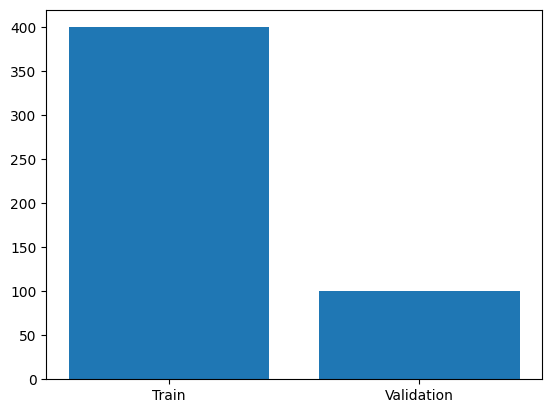

In [63]:
plt.bar(['Train','Validation'],[dataset['train'].num_rows,dataset['validation'].num_rows])
plt.show()

{'pixel_values': <PIL.PngImagePlugin.PngImageFile image mode=L size=512x512 at 0x3302F6ED0>, 'label': <PIL.PngImagePlugin.PngImageFile image mode=L size=512x512 at 0x331ED9100>}
Image(mode=None, decode=True, id=None)
Image/Mask dims (512, 512) (512, 512)
Image/Mask type uint8 uint8
Image min, max 0 255
Mask min, max 0 255
Labels in mask [  0 255]


Text(0.5, 1.0, 'Mask')

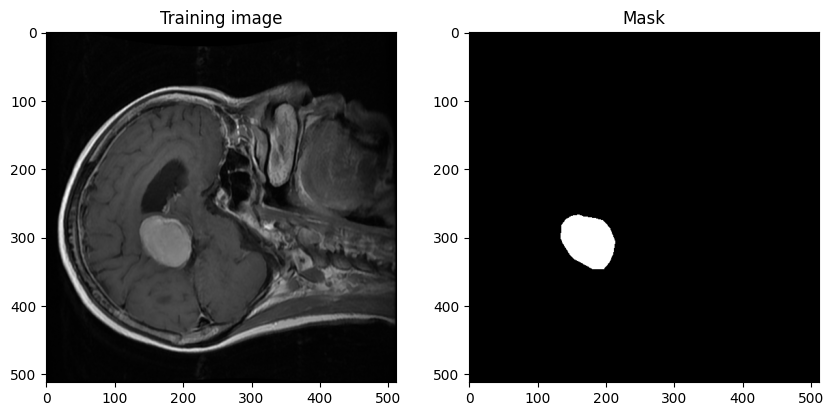

In [65]:
import numpy as np
# Get an example from the training dataset
example = split_dataset["train"][0]
# Convert pixel values and label to NumPy arrays
im = np.array(example['pixel_values'])
mask = np.array(example['label'])

print("Image/Mask dims", im.shape, mask.shape)
print("Image/Mask type", im.dtype, mask.dtype)
print("Image min, max", im.min(), im.max())
print("Mask min, max", mask.min(), mask.max())
print("Labels in mask", np.x(mask))

# Visualize the image and mask side by side
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(221)

# Display the training image
ax1.imshow(im, cmap='gray')
ax1.set_title('Training image')

ax2 = fig.add_subplot(222)

# Display the corresponding mask
ax2.imshow(mask, cmap='gray')
ax2.set_title('Mask')


In [ ]:
def IntersectionOverUnion(y_label,y_pred):
    
    # overlap (Logical AND)
    overlap = y_label*y_pred
    union = y_label+y_pred

    IOU = overlap.sum()/float(union.sum()+ 1e-9)